# Third model: Training specialists

A pipeline of specialist CNNs with early stopping and supervised pre-training.

## Early stopping, loading pre-trained model.

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import matplotlib
from matplotlib import pyplot
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from nolearn.lasagne import BatchIterator
import tensorflow as tf

/home/ubuntu/anaconda2/envs/tf/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


## Loading data

Paths to datasets.

In [2]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/data/training.csv'
FTEST = FROOT + '/data/test.csv'
FLOOKUP = FROOT + '/data/IdLookupTable.csv'

In [4]:
def load(test=False, cols=None):
    """
    Loads the dataset.

    Parameters
    ----------
    test     : optional, defaults to `False`
               Flag indicating if we need to load from `FTEST` (`True`) or FTRAIN (`False`)
    cols     : optional, defaults to `None`
               A list of columns you're interested in. If specified only returns these columns.
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [5]:
def plot_sample(x, y, axis):
    """
    Plots a single sample image with keypoints on top.

    Parameters
    ----------
    x     : Image data.
    y     : Keypoints to plot.
    axis  : Plot over which to draw the sample.
    """
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [6]:
num_channels = 1 # grayscale
image_size = 96

def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, image_size, image_size, num_channels)
    return X, y

## Parameters

Predefined parameters:

In [7]:
batch_size = 36
every_epoch_to_log = 5

root_location = FROOT + "/models/"

In [9]:
def model_name(spec_name):
    """
    Generates model name for a specialist.
    """
    return "spec_" + spec_name

def model_path(spec_name):
    """
    Generates model path for a specialist.
    """
    return root_location + "specialists/" + model_name(spec_name) + "/model.ckpt"

def train_history_path(spec_name):
    """
    Generates path to a training history file for a specialist.
    """
    return root_location + "specialists/" + model_name(spec_name) + "/train_history"

def create_directory_for_specialist(spec_name):
    """
    Creates necessary folders for a specialist.
    """
    os.makedirs(root_location + "specialists/" + model_name(spec_name) + "/", exist_ok=True)

## Specialists

In [10]:
SPECIALIST_SETTINGS = [
    dict(
        name = "eye_center",
        columns = (
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "nose_tip",
        columns = (
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices = ((0, 2), (1, 3)),
        ),

    dict(
        name = "mouth_bottom",
        columns = (
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices = (),
        ),

    dict(
        name = "eye_corner",
        columns = (
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices = ((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

## Routines

This is our data augmentation routine. It randomly flips a defined portion of dataset horizontally.

In [11]:
class FlipBatchIterator(BatchIterator):
    """
    Batch iterator that randomly flips a defined portion of dataset horizontally.
    """

    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

This is our early stopping routine.

In [12]:
class EarlyStopping(object):
    """
    Provides early stopping functionality. Keeps track of model training value,
    and if it doesn't improve over time restores last best performing parameters.
    """

    def __init__(self, saver, session, patience=100, minimize=True):
        """
        Initialises a `EarlyStopping` instance.

        Parameters
        ----------
        saver     : TensorFlow Saver object to be used for saving and restoring model.
        session   : TensorFlow Session object containing graph where model is restored.
        patience  : Early stopping patience. This is the number of epochs we wait for the tracked
                    value to start improving again before stopping and restoring 
                    previous best performing parameters.
        """
        self.minimize = minimize
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_epoch = 0
        self.restore_path = None

    def __call__(self, value, epoch):
        """
        Checks if we need to stop and restores the last well performing values if we do.

        Parameters
        ----------
        value : Last epoch monitored value.
        epoch : Last epoch number.

        Returns
        -------
        `True` if we waited enough and it's time to stop and we restored the
        best performing weights, or `False` otherwise.
        """
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True

        return False

Performs a single fully connected layer pass, e.g. returns input * weights + bias:

In [14]:
def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.

    Parameters
    ----------
    input  : Input tensor for calculating layer shape.
    size   : Layer size, e.g. number of units.
  
    Returns
    -------
    A graph variable calculating single fully connected layer.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    """
    Creates a fully connected TensorFlow layer with ReLU non-linearity applied.
    """
    return tf.nn.relu(fully_connected(input, size))

Routine for a single convolution layer pass.

In [15]:
def conv_relu(input, kernel_size, depth):
    """
    Creates a convolutional TensorFlow layer followed by a ReLU.

    Parameters
    ----------
    input         : Input tensor for calculating layer shape.
    kernel_size   : Kernel size, we assume a square kernel.
    depth         : Layer depth, e.g. number of units.

    Returns
    -------
    A graph variable calculating convolutional layer with applied ReLU.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer=tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

Routine for a pooling layer.

In [16]:
def pool(input, size):
    """
    Performs max pooling.

    Parameters
    ----------
    input  : Input tensor.
    size   : Pooling kernel size, assuming it's square.

    Returns
    -------
    A graph variable calculating single max pooling layer.
    """
    return tf.nn.max_pool(
        input, 
        ksize=[1, size, size, 1],
        strides=[1, size, size, 1],
        padding='SAME'
    )

Routine that performs entire model pass, e.g. returns model prediction for given input with current model (3 convolution layers with 2 fully connected layers):

In [17]:
def model_pass(input, keypoints, training):
    """
    Performs a whole model pass.

    Parameters
    ----------
    input     : Input tensor to be passed through the model.
    keypoints : Number of keypoints.
    training  : Tensorflow flag indicating if we are training or evaluating our model
                (so that we know if we should apply dropout).

    Returns
    -------
    Model prediction.
    """
    # Convolutional layers
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = 3, depth = 32)
        pool1 = pool(conv1, size = 2)
        # Apply dropout if needed
        pool1 = tf.cond(training, lambda: tf.nn.dropout(pool1, keep_prob = 0.9), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
        pool2 = pool(conv2, size = 2)
        # Apply dropout if needed
        pool2 = tf.cond(training, lambda: tf.nn.dropout(pool2, keep_prob = 0.8), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
        pool3 = pool(conv3, size = 2)
        # Apply dropout if needed
        pool3 = tf.cond(training, lambda: tf.nn.dropout(pool3, keep_prob = 0.7), lambda: pool3)

    # Flatten convolutional layers output
    shape = pool3.get_shape().as_list()
    flattened = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])

    # Fully connected layers
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = 1000)
        # Apply dropout if needed
        fc4 = tf.cond(training, lambda: tf.nn.dropout(fc4, keep_prob = 0.5), lambda: fc4)
    with tf.variable_scope('fc5'):
        fc5 = fully_connected_relu(fc4, size = 1000)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc5, size = keypoints)
    return prediction

Calculates loss based on model predictions.

In [18]:
def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.

    Parameters
    ----------
    predictions : ndarray
                  Predictions.
    labels      : ndarray
                  Actual values.

    Returns
    -------
    Squared mean error for given predictions.
    """
    return np.mean(np.square(predictions - labels))

Calculates time since start and formats as a string.

In [19]:
def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.

    Parameters
    ----------
    start : Time starting point.

    Returns
    -------
    Nicely formatted time difference between now and `start`.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [20]:
def get_predictions_in_batches(X, session, predictions, tf_x_batch, is_training):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.

    Parameters
    ----------
    X           : ndarray
                  Dataset to get predictions for.
    session     : TensorFlow session to be used for predicting. Is expected to have a `predictions` var
                  in the graph along with a `tf_x_batch` placeholder for incoming data.
    predictions : TensorFlow variable from the graph in `session` with model predictions.
    tf_x_batch  : TensorFlow placeholder from the graph in `session` with data batch.
    is_training : TensorFlow placeholder from the graph in `session` with a flag indicating if we're training or testing.

    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, y_batch in batch_iterator(X):
        [p_batch] = session.run([predictions], feed_dict = {
                tf_x_batch : x_batch,
                is_training : False
            }
        )
        p.extend(p_batch)
    return p

In [21]:
def train_specialist(spec_setting):
    """
    Trains a single specialist as per its settings.

    Parameters
    ----------
    spec_setting : Specialist settings.
    """

    # Initialising routines:

    # Load data and split into datasets
    X, y = load2d(cols=spec_setting['columns'])
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5)

    # Work out some specialist settings and prepare the file paths
    spec_name = spec_setting['name']
    create_directory_for_specialist(spec_name)
    spec_var_scope = model_name(spec_name)
    initialising_model = "3con_2fc_b36_e1000_aug_lrdec_mominc_dr"

    # Calculate some of the training hyperparameters based on the specialist and available data
    max_epochs = int(1e7 / y.shape[0])
    num_keypoints = y.shape[1]

    # Note training time start
    spec_start = time.time()

    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, num_keypoints))
        is_training = tf.placeholder(tf.bool)

        current_epoch = tf.Variable(0)  # count the number of epochs

        # Model parameters.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = max_epochs, decay_rate = 0.03)
        momentum = 0.9 + (0.99 - 0.9) * (current_epoch / max_epochs)

        # Training computation.
        with tf.variable_scope(spec_var_scope):
            predictions = model_pass(tf_x_batch, num_keypoints, is_training)

        loss = tf.reduce_mean(tf.square(predictions - tf_y_batch))

        # Optimizer.
        optimizer = tf.train.MomentumOptimizer(
            learning_rate = learning_rate,
            momentum = momentum,
            use_nesterov = True
        ).minimize(loss)

    # Initiate training
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(saver, session)
        train_loss_history = np.zeros(max_epochs)
        valid_loss_history = np.zeros(max_epochs)

        print("======= RESTORING SESSION =======")
        # Exclude output layer weights from variables we will restore
        variables_to_restore = [v for v in tf.global_variables() if "/out/" not in v.op.name]
        # Replace variables scope with that of the current model
        loader = tf.train.Saver({v.op.name.replace(spec_var_scope, initialising_model): v for v in variables_to_restore})
        load_path = root_location + initialising_model + "/model.ckpt"
        loader.restore(session, load_path)
        print(" Model loaded from: " + load_path)

        print("======= TRAINING: " + spec_name.replace("_", " ").upper() + " on " + str(y.shape[0]) + " EXAMPLES ========")
        for epoch in range(max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = FlipBatchIterator(batch_size=batch_size, shuffle=True)
            batch_iterator.flip_indices = spec_setting['flip_indices']
            for x_batch, y_batch in batch_iterator(x_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch,
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            # Get validation data predictions and log validation loss:
            valid_loss = calc_loss(
                get_predictions_in_batches(x_valid, session, predictions, tf_x_batch, is_training),
                y_valid
            )
            valid_loss_history[epoch] = valid_loss
            
            # If another significant epoch ended, we log our losses.
            if (epoch % every_epoch_to_log == 0):
                # Get training data predictions and log training loss:
                train_loss = calc_loss(
                    get_predictions_in_batches(x_train, session, predictions, tf_x_batch, is_training),
                    y_train
                )
                train_loss_history[epoch] = train_loss

                if (epoch % 100 == 0):
                    print("--------- EPOCH %4d/%d ---------" % (epoch, max_epochs))
                    print("     Train loss: %.8f" % (train_loss))
                    print("Validation loss: %.8f" % (valid_loss))
                    print("           Time: " + get_time_hhmmss(spec_start))

            if early_stopping(valid_loss, epoch): break
            
        # Evaluate on test dataset.
        test_loss = calc_loss(
            get_predictions_in_batches(x_test, session, predictions, tf_x_batch, is_training),
            y_test
        )
        print("=========== " + spec_name.replace("_", " ").upper() + ": ============")
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss))
        print(" Total time: " + get_time_hhmmss(spec_start))

        # Save model weights for future use.
        save_path = saver.save(session, model_path(spec_name))
        print("Model file: " + save_path)
        np.savez(train_history_path(spec_name), train_loss_history = train_loss_history, valid_loss_history = valid_loss_history)
        print("Train history file: " + train_history_path(spec_name))
        print("\n")

In [22]:
start = time.time()

for spec_setting in SPECIALIST_SETTINGS:
    train_specialist(spec_setting)
    
print("====== ALL SPECIALISTS TRAINED =======")
print(" Total time: " + get_time_hhmmss(start))

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64
======= RESTORING SESSION =======
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/3con_2fc_b36_e1000_aug_lrdec_mominc_dr/model.ckpt
 Model loaded from: /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/3con_2fc_b36_e1000_aug_lrdec_mominc_dr/model.ckpt
======= TRAINING: EYE CENTER on 7033 EXAMPLES ========
--------- EPOCH    0/1421 ---------
     Train loss: 0.00300575
Validation loss: 0.00423222
           Time: 00:00:09
--------- EPOCH  100/1421 ---------
     Train loss: 0.00122885
Validation loss: 0.00298991
           Time: 00:10:17
--------- EPOCH  200/1421 ---------
     Train loss: 0.00087466
Validation loss: 0.00287036
           Time: 00:20:06
--------- EPOCH  300/1421 ---------
     Train loss: 0.00069299
Validation loss: 0.00273809
       

left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
Image                        7049
dtype: int64
======= RESTORING SESSION =======
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/3con_2fc_b36_e1000_aug_lrdec_mominc_dr/model.ckpt
 Model loaded from: /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/3con_2fc_b36_e1000_aug_lrdec_mominc_dr/model.ckpt
======= TRAINING: EYEBROW on 2190 EXAMPLES ========
--------- EPOCH    0/4566 ---------
     Train loss: 0.00474460
Validation loss: 0.00455406
           Time: 00:00:03
--------- EPOCH  100/4566 ---------
     Train loss: 0.00157584
Validation loss: 0.00137231
           Time: 00:03:55
--------- EPOCH  200/4566 ---------
     Train lo

## Evaluation

Plots history of learning curves for a specific model. You may want to call `pyplot.show()` afterwards.

In [23]:
def plot_learning_curves(spec_name, color):
    """
    Plots history of learning curves for a specific specialist based on the saved training history.
    You may want to call `pyplot.show()` afterwards.

    Parameters
    ----------
    spec_name   : Specialist name.
    color       : Line color.

    Returns
    -------
    Number of epochs plotted.
    """
    model_history = np.load(train_history_path(spec_name) + ".npz")
    train_loss = model_history["train_loss_history"]
    valid_loss = model_history["valid_loss_history"]
    epochs = train_loss.shape[0]
    x_axis = np.arange(epochs)
    pyplot.plot(x_axis[train_loss > 0], train_loss[train_loss > 0], color + "--", linewidth=2, label = spec_name.replace("_", " ").title())
    pyplot.plot(x_axis[valid_loss > 0], valid_loss[valid_loss > 0], color + "-", linewidth=2)
    return epochs

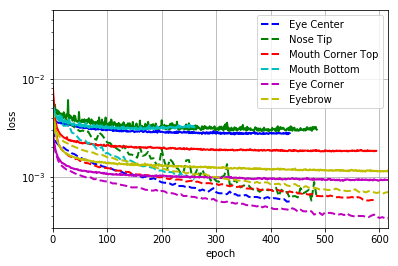

In [24]:
max_model_epochs = 0
colors = ["b", "g", "r", "c", "m", "y", "k", "w"]
for spec_setting in SPECIALIST_SETTINGS:
    spec_epochs = plot_learning_curves(spec_setting['name'], colors[SPECIALIST_SETTINGS.index(spec_setting) % len(colors)])
    if spec_epochs > max_model_epochs:
        max_model_epochs = spec_epochs

pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.0003, 0.05)
pyplot.xlim(0, 615)
pyplot.yscale("log")
pyplot.show()

## Submission

Submission generating routines.

In [25]:
from datetime import datetime

def evaluate_specialist(X, spec_name, num_keypoints):
    # Work out some specialist settings and prepare the file paths
    spec_var_scope = model_name(spec_name)

    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, image_size, image_size, num_channels))
        is_training = tf.placeholder(tf.bool)

        with tf.variable_scope(spec_var_scope, reuse = False):
            tf_p_batch = model_pass(tf_x_batch, num_keypoints, is_training)

    with tf.Session(graph = graph) as session:
        saver = tf.train.Saver()
        saver.restore(session, model_path(spec_name))
        p = []
        batch_iterator = BatchIterator(batch_size=128)
        for x_batch, _ in batch_iterator(X):
            [p_batch] = session.run([tf_p_batch], feed_dict = {
                    tf_x_batch : x_batch,
                    is_training : False
                }
            )
            p.extend(p_batch)
        return p

In [27]:
def generate_submission():
    X = load2d(test=True)[0]
    y_pred = np.empty((X.shape[0], 0))

    columns = ()
    for spec_setting in SPECIALIST_SETTINGS:
        p = evaluate_specialist(X, spec_setting['name'], len(spec_setting['columns']))
        y_pred = np.hstack([y_pred, p])
        columns += spec_setting['columns']

    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = DataFrame(y_pred2, columns=columns)

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = root_location + 'specialists/submission-{}.csv'.format(now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))

Finally, generate your submission!

In [28]:
generate_submission()

ImageId    1783
Image      1783
dtype: int64
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_eye_center/model.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_nose_tip/model.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_mouth_corner_top/model.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_mouth_bottom/model.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_eye_corner/model.ckpt
INFO:tensorflow:Restoring parameters from /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/spec_eyebrow/model.ckpt


/home/ubuntu/anaconda2/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Wrote /home/ubuntu/development/gh-repo/kaggle-facial-detection/notebooks/models/specialists/submission-2018-02-01T09-13-02.308832.csv
